# Seattle Building Energy Forecasting

URL: https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking

## Notebook n°5 - Modelling

Objective: Create dummy variables and try different models

---

## Import librairies

In [3]:
import time
import warnings
import re
import pickle
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
import xgboost as xgb

## Settings

In [4]:
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 200

target1 = "SiteEnergyUse(kBtu)"
target2 = "TotalGHGEmissions"

TARGET = target2

## Import data

In [5]:
with open("data/part4.pkl", "rb") as f:
    my_unpickler = pickle.Unpickler(f)
    data = my_unpickler.load()
    
with open("data/part4-data-with-outliers.pkl", "rb") as f:
    my_unpickler = pickle.Unpickler(f)
    data_with_outliers = my_unpickler.load()

## Functions

### Dummify variables

In [6]:
def onehot(data, feature):
    
    # Get dummy variables
    temp_df = pd.get_dummies(data[feature])
    
    # Add prefix to prevent duplicated feature names
    temp_df = temp_df.add_prefix(feature + "_")
    
    # Concatenante the new features with the main dataframes
    data = pd.concat([data, temp_df], axis=1)
    
    # Drop the original feature
    data.drop(feature, axis=1, inplace=True)
    
    # Return the new dataframe
    return data

### Prepare datasets

In [7]:
def prepare_data(data, energystarscore="fill"):
    
    # Copy original data
    data_copy = data.copy()
    
    # Building Type
    data_copy = onehot(data_copy, "BuildingType")
    
    # CouncilDistrictCode
    data_copy = onehot(data_copy, "CouncilDistrictCode")
    
    # Neighborhood
    data_copy = onehot(data_copy, "Neighborhood")
    
    # LargestPropertyUseType
    data_copy = onehot(data_copy, "LargestPropertyUseType")
    
    # PrimaryPropertyType
    data_copy = onehot(data_copy, "PrimaryPropertyType")
    
    # DataYear
    data_copy.drop("DataYear", axis=1, inplace=True)
    
    # Address
    data_copy.drop("Address", axis=1, inplace=True)
    
    # address_type
    data_copy.drop("address_type", axis=1, inplace=True)
    
    # lat_long_range
    data_copy.drop("lat_long_range", axis=1, inplace=True)
    
    # ZipCode
    data_copy.drop("ZipCode", axis=1, inplace=True)
    
    # default_data
    data_copy.drop("default_data", axis=1, inplace=True)
    
    # ENERGYSTARScore
    if (energystarscore == "fill"):
        data_copy["ENERGYSTARScore"].fillna(data_copy["ENERGYSTARScore"].dropna().mean(), inplace=True)
    elif (energystarscore == "drop"):
        mask = data_copy["ENERGYSTARScore"].isna()
        data_copy = data_copy[~mask]

    return data_copy.reset_index(drop=True)

### Random Forest Model

In [8]:
def my_rf(data, target, param_grid, test_size, target_log=False):

    X = data.drop(target, axis=1)
    y = data[target]
    
    if target_log:
        y = np.log(data[target])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    score = 'neg_mean_squared_error'

    # Cross validation classifier to get best parameters from the grid search
    clf_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring=score)
    clf_rf.fit(X_train_scaled, y_train)
    params = clf_rf.best_params_
        
    # Train prediction
    y_train_pred = clf_rf.predict(X_train_scaled)
    
    # Test prediction
    y_test_pred = clf_rf.predict(X_test_scaled)
    
    ############## Scores ##############
    
    # Get back to exponantial if we are in log for the target
    if target_log:
        y_train_pred = np.exp(y_train_pred)
        y_train = np.exp(y_train)
        y_test_pred = np.exp(y_test_pred)
        y_test = np.exp(y_test)
    
    # Compute R2 and RMSE for both training set and test set
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Push the score in a dict
    scores = {
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'test_rmse': test_rmse,
        'test_r2': test_r2
    }
    
    # Return the classifier, y test and scores
    return clf_rf, y_test, y_test_pred, scores, X_test_scaled

### XGboost Model

In [9]:
import itertools
from joblib import Parallel
from joblib import delayed
from multiprocessing import cpu_count
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold

def perform_xgb(the_params, params_keys, X_train_scaled, y_train, kf, X_test_scaled=None, y_test=None):
    """This function is called by my_xgb() function. """
    
    ############################################################
    # Construct the "temp_params" dictionary
    ############################################################
    
    temp_params = {the_key: the_params[i] for i, the_key in enumerate(params_keys)}
    
    ############################################################
    # Cross Validation - Iterate over folds
    ############################################################
    
    # Cumulated scores
    temp_scores = {
        'r2':[],
        'rmse':[]
    }
    
    # Train / test over each fold
    for train_index, test_index in kf.split(X_train_scaled):

        # Train / Test split

        # X is a numpy array, so we just need to use indexes returned by the split
        X_train_cv, X_test_cv = X_train_scaled[train_index], X_train_scaled[test_index]

        # y is an indexed Pandas series, so we need to use .iloc
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # Train the model
        clf = xgb.XGBRegressor(**temp_params)
        clf.fit(X_train_cv, y_train_cv)

        # Prediction / Score
        y_test_cv_pred = clf.predict(X_test_cv)
        temp_scores['r2'].append(r2_score(y_test_cv, y_test_cv_pred))
        temp_scores['rmse'].append(np.sqrt(mean_squared_error(y_test_cv, y_test_cv_pred)))

    # Train the model on the entire train set
    clf = xgb.XGBRegressor(**temp_params)
    clf.fit(X_train_scaled, y_train)

    # Prediction / Score on the training set
    y_train_pred = clf.predict(X_train_scaled)
    train_r2_score = r2_score(y_train, y_train_pred)
    train_rmse_score = np.sqrt(mean_squared_error(y_train, y_train_pred))

    # Prediction / Score on the test set
    if X_test_scaled is not None:
        y_test_pred = clf.predict(X_test_scaled)
        test_r2_score = r2_score(y_test, y_test_pred)
        test_rmse_score = np.sqrt(mean_squared_error(y_test, y_test_pred))
        
    else:
        test_r2_score = np.nan
        test_rmse_score = np.nan

    # Save the final scores for the given params
    def_params = temp_params
    cv_r2_score = np.mean(temp_scores['r2'])
    cv_rmse_score = np.mean(temp_scores['rmse'])
    train_r2_score = train_r2_score
    train_rmse_score = train_rmse_score
    def_model = clf
        
    # Return the result. It's corresponding to a row of the final results dataframe.
    return temp_params, cv_r2_score, cv_rmse_score, train_r2_score, train_rmse_score, test_r2_score, test_rmse_score, def_model 

def my_xgb(data, params, target, test_size=0.2, parallel=True):
    """This function performs a cross-validation test on the given data. For now, it's designed to run with the XGBoost algorithm.
    
    First, it splits the features and the target.
    Then, it performs a train / test split if test_size != 0.
    Then, it performs a K-Folds cross-validation by creating folds with sklearn.model_selection.KFold.
    Finally, for each parameters combination it gives :
    - The cross-validation score
    - The training score
    - The test score (if test_size != 0)
    
    The scores are R2 and RMSE, so the function is designed only for regression so far.
    
    Args:
    
        data (Pandas Dataframe): the original dataset
        params (dict): the grid-search parameters. Each value has to be a list
        target (str): The name of the target as written in the dataset column
        test_size (float): The proportion of the test set ([0, 1[)
        
    Returns:
        Dict: All the results for each parameters combination plus the corresponding model trained on the entire training set.
    
    """
    
    #########################################################################
    # Prepare data : X / y split, then Train / test split, then scale
    #########################################################################
    
    X = data.drop(target, axis=1)
    y = data[target]
    
    if test_size != 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        
    else:
        X_train, X_test, y_train, y_test = X, X, y, y

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    #########################################################################
    # Prepare params for gridsearch. Compute all combinations
    #########################################################################
    
    params_keys = list(params.keys())
    params_product = list(itertools.product(*list(params.values())))
    
    #########################################################################
    # Prepare folds for cross-validation
    #########################################################################
    
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    
    #########################################################################
    # Parse all params combinations and format the results
    #########################################################################
    
    if parallel:
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(perform_xgb)(the_params, params_keys, X_train_scaled, y_train, kf, X_test_scaled, y_test) for the_params in params_product)
        results = executor(tasks)
        
    else:
        results = [perform_xgb(the_params, params_keys, X_train_scaled, y_train, kf, X_test_scaled, y_test) for the_params in params_product]
    
    # From an array of tuples to a Pandas Dataframe
    the_cols = ["params", "cv_r2_score", "cv_rmse_score", "train_r2_score", "train_rmse_score", "test_r2_score", "test_rmse_score", "model"]
    results = pd.DataFrame(results, columns=the_cols).sort_values(by="cv_rmse_score", ascending=False)
    
    # Return results. If there is a test set, return it
    if test_size != 0:
        return results, X_test_scaled, y_test
    
    else:
        return results

### Errors Analysis

In [10]:
def error_analysis(X, y_true, y_pred):
    
    errors = y_pred - y_true
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(y_true, y_pred, alpha=0.2)
    plt.title("y_pred as a function of y_true", fontweight="bold")
    plt.xlabel("y_true", fontweight="bold")
    plt.ylabel("y_pred", fontweight="bold")
    plt.show()
    
    sns.distplot(errors, kde=False)
    plt.title("Errors distribution", fontweight="bold")
    plt.xlabel("Error value", fontweight="bold")
    plt.ylabel("Total errors", fontweight="bold")
    plt.show()
    
    sns.scatterplot(y_true, errors, alpha=0.2)
    plt.title("Error value as a function of y_true", fontweight="bold")
    plt.xlabel("y_true", fontweight="bold")
    plt.ylabel("Error value", fontweight="bold")
    plt.show()
    
    sns.scatterplot(X[:,0], errors, alpha=0.2)
    plt.title("Error value as a function of YearBuilt", fontweight="bold")
    plt.xlabel("YearBuilt", fontweight="bold")
    plt.ylabel("Error value", fontweight="bold")
    plt.show()
    
    sns.scatterplot(X[:,1], errors, alpha=0.2)
    plt.title("Error value as a function of NumberofFloors", fontweight="bold")
    plt.xlabel("NumberofFloors", fontweight="bold")
    plt.ylabel("Error value", fontweight="bold")
    plt.show()
    
    sns.scatterplot(X[:,2], errors, alpha=0.2)
    plt.title("Error value as a function of LargestPropertyUseTypeGFA", fontweight="bold")
    plt.xlabel("LargestPropertyUseTypeGFA", fontweight="bold")
    plt.ylabel("Error value", fontweight="bold")
    plt.show()

## Prepare datasets

In [11]:
data_prep = prepare_data(data)
data_with_outliers_prep = prepare_data(data_with_outliers)

In [12]:
data_prep.head()

,YearBuilt,NumberofFloors,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Latitude,Longitude,BuildingType_Campus,BuildingType_Multifamily HR (10+),...,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_Supermarket/Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility
0,1927,12.0,88434.0,65.000000,6981428.0,249.43,47.612190,-122.337997,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1996,11.0,83880.0,51.000000,8354235.0,263.51,47.613106,-122.333358,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1999,2.0,88830.0,68.541702,12051984.0,304.62,47.616439,-122.336764,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1926,11.0,81352.0,25.000000,6252842.0,208.46,47.614114,-122.332741,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1926,8.0,102761.0,68.541702,6426022.0,199.99,47.612902,-122.331309,0,0,...,0,0,0,0,0,0,0,0,0,0


### Site Energy Use - Random Forest

#### Modelization

In [13]:
param_grid = {'n_estimators': [600],
              'max_features': ['auto'],
              'n_jobs': [-1],
              'random_state': [42],
              'max_depth': [None],
              'min_samples_leaf': [1],
              'min_samples_split': [2],
              }

#### Display results

In [14]:
regressor1, y_test1, y_pred1, scores1, X_test1 = my_rf(data_prep.drop([target2, "ENERGYSTARScore"], axis=1), target1, param_grid, test_size=0.20)
display(regressor1.best_params_)
display(scores1)

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 600,
 'n_jobs': -1,
 'random_state': 42}

{'train_rmse': 526155.9997101225,
 'train_r2': 0.9801344581186169,
 'test_rmse': 1232320.5184747213,
 'test_r2': 0.8801388862977408}

#### Feature importances

In [15]:
feature_importances1 = regressor1.best_estimator_.feature_importances_
feature_names1 = data_prep.drop([target1, target2, "ENERGYSTARScore"], axis=1).columns

temp_df1 = {
    'feature_names': feature_names1,
    'feature_importances': feature_importances1
}

temp_df1 = pd.DataFrame(temp_df1).sort_values(by="feature_importances", ascending=False)

display(temp_df1.head(10))

,feature_names,feature_importances
2,LargestPropertyUseTypeGFA,0.594494
89,LargestPropertyUseType_Supermarket/Grocery Store,0.045499
4,Longitude,0.043678
60,LargestPropertyUseType_Office,0.037703
3,Latitude,0.036732
0,YearBuilt,0.035631
1,NumberofFloors,0.031082
101,PrimaryPropertyType_Large Office,0.015965
57,LargestPropertyUseType_Multifamily Housing,0.013540
9,BuildingType_NonResidential,0.012395


### Site Energy Use - XGboost

#### Modelization

In [57]:
params = {'max_depth': [50],
          'learning_rate': [0.2], # (XGBoost eta)
          'min_child_weight': [1],
          'subsample': [1],
          'colsample_bytree': [0.7],
          'objective': ['reg:squarederror'],
          'n_jobs': [4],
          'gamma': [0],
          'reg_lambda': [1],
          'n_estimators':[50]}

regressor2, X_test2, y_test2 = my_xgb(data_prep.drop([target2, "ENERGYSTARScore"], axis=1), params, target1)
model2 = regressor2["model"].iloc[0]

#### Display results

In [58]:
display(pd.DataFrame(regressor2).sort_values(by="test_rmse_score").head(5))
display(model2.get_params())

,params,cv_r2_score,cv_rmse_score,train_r2_score,train_rmse_score,test_r2_score,test_rmse_score,model
0,"{'max_depth': 50, 'learning_rate': 0.2, 'min_c...",0.828162,1.544768e+06,0.999989,12129.554133,0.924552,977704.204362,"XGBRegressor(base_score=0.5, booster='gbtree',..."


{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.2,
 'max_delta_step': 0,
 'max_depth': 50,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 50,
 'n_jobs': 4,
 'nthread': None,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

#### Feature importances

In [18]:
feature_importances = model2.feature_importances_
feature_names = data_prep.drop([target1, target2, "ENERGYSTARScore"], axis=1).columns

temp_df2 = {
    'feature_name': feature_names,
    'feature_importance': feature_importances
}

temp_df2 = pd.DataFrame(temp_df2).sort_values(by="feature_importance", ascending=False)

display(temp_df2.reset_index(drop=True).head(10))

,feature_name,feature_importance
0,PrimaryPropertyType_Large Office,0.480422
1,LargestPropertyUseType_Supermarket/Grocery Store,0.066009
2,PrimaryPropertyType_Low-Rise Multifamily,0.046958
3,LargestPropertyUseType_Multifamily Housing,0.043867
4,PrimaryPropertyType_Supermarket/Grocery Store,0.029414
5,LargestPropertyUseType_Lifestyle Center,0.022743
6,LargestPropertyUseType_Urgent Care/Clinic/Othe...,0.022691
7,LargestPropertyUseType_Police Station,0.018255
8,PrimaryPropertyType_Supermarket / Grocery Store,0.016226
9,LargestPropertyUseType_Laboratory,0.013573


#### Errors analysis

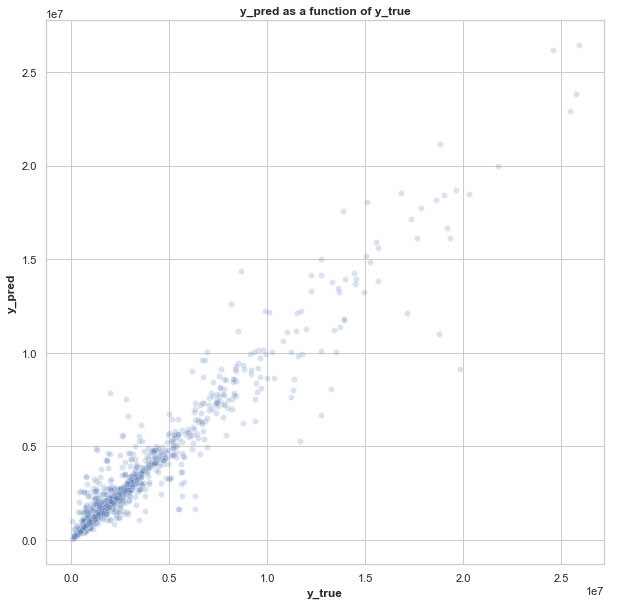

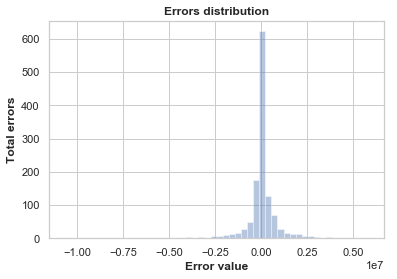

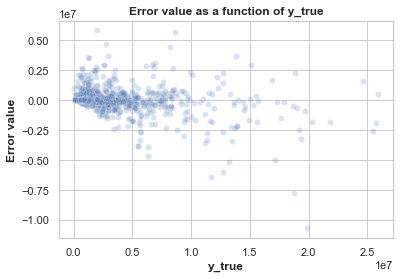

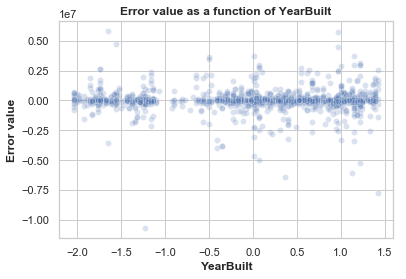

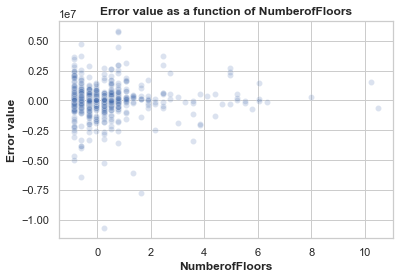

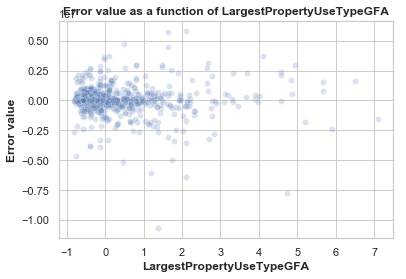

In [19]:
y_pred2 = model2.predict(X_test2)
error_analysis(X_test2, y_test2, y_pred2)

### TotalGHGEmissions - Random Forest

#### Modelization

In [20]:
param_grid = {'n_estimators': [600],
              'max_features': ['auto'],
              'n_jobs': [-1],
              'random_state': [42],
              'max_depth': [None],
              'min_samples_leaf': [1],
              'min_samples_split': [2],
              }

regressor3, y_test3, y_pred3, scores3, X_test3 = my_rf(data_prep.drop([target1, "ENERGYSTARScore"], axis=1), target2, param_grid, test_size=0.20)

#### Display results

In [21]:
display(regressor3.best_params_)
display(scores3)

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 600,
 'n_jobs': -1,
 'random_state': 42}

{'train_rmse': 13.987750720462152,
 'train_r2': 0.9670989103619538,
 'test_rmse': 34.97916622007727,
 'test_r2': 0.7590951857661303}

### TotalGHGEmissions - XGBoost

#### Modelization

In [30]:
params = {'max_depth': [55],
          'learning_rate': [0.3],
          'min_child_weight': [1],
          'subsample': [1],
          'colsample_bytree': [0.7],
          'objective': ['reg:squarederror'],
          'n_estimators': [50],
          'n_jobs': [4]}

regressor4, X_test4, y_test4 = my_xgb(data_prep.drop([target1, "ENERGYSTARScore"], axis=1), params, target2)
model4 = regressor4["model"].iloc[0]

#### Display results

In [23]:
display(pd.DataFrame(regressor4).sort_values(by="cv_rmse_score").head(20))
display(model4.get_params())

,params,cv_r2_score,cv_rmse_score,train_r2_score,train_rmse_score,test_r2_score,test_rmse_score,model
0,"{'max_depth': 55, 'learning_rate': 0.3, 'min_c...",0.719618,40.756242,0.99999,0.2388,0.793547,32.381493,"XGBRegressor(base_score=0.5, booster='gbtree',..."


{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.3,
 'max_delta_step': 0,
 'max_depth': 55,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 50,
 'n_jobs': 4,
 'nthread': None,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

#### Feature importances

In [24]:
feature_importances4 = model4.feature_importances_
feature_names4 = data_prep.drop([target1, target2, "ENERGYSTARScore"], axis=1).columns

temp_df4 = {
    'feature_name': feature_names4,
    'feature_importance': feature_importances4
}

temp_df4 = pd.DataFrame(temp_df4).sort_values(by="feature_importance", ascending=False)

display(temp_df4.reset_index(drop=True).head(10))

,feature_name,feature_importance
0,LargestPropertyUseType_Supermarket/Grocery Store,0.106051
1,LargestPropertyUseType_Multifamily Housing,0.080717
2,PrimaryPropertyType_Low-Rise Multifamily,0.078950
3,PrimaryPropertyType_Supermarket/Grocery Store,0.059503
4,PrimaryPropertyType_Mid-Rise Multifamily,0.059243
5,LargestPropertyUseType_Laboratory,0.040314
6,LargestPropertyUseType_Restaurant,0.039659
7,PrimaryPropertyType_Supermarket / Grocery Store,0.035168
8,PrimaryPropertyType_Hotel,0.031066
9,PrimaryPropertyType_Senior Care Community,0.023963


#### Errors Analysis

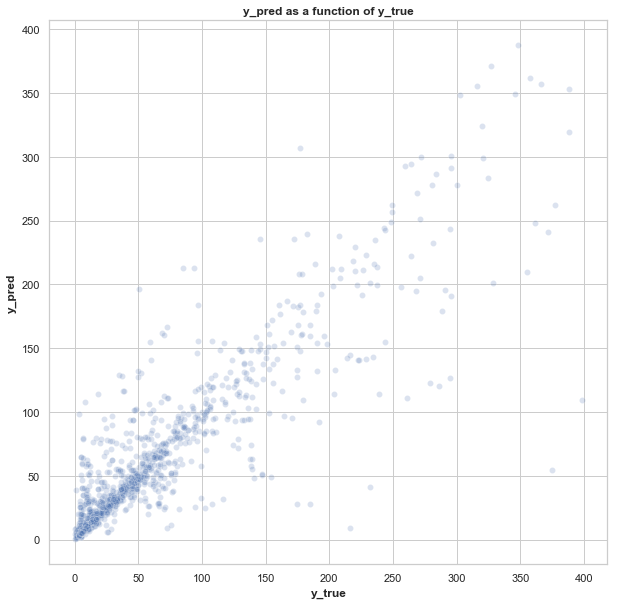

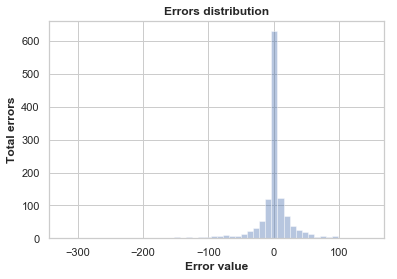

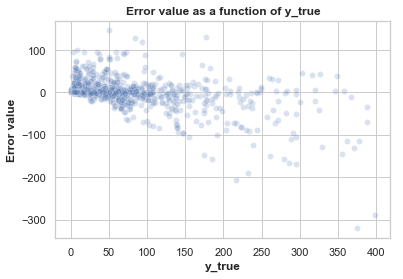

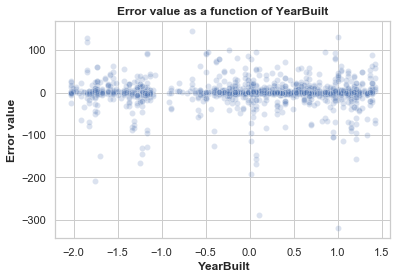

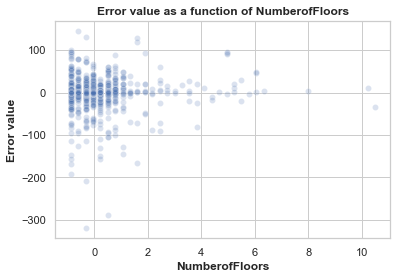

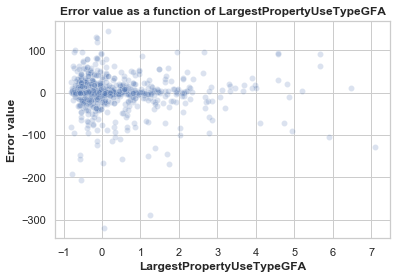

In [25]:
y_pred4 = model4.predict(X_test4)
error_analysis(X_test4, y_test4, y_pred4)

## Special cases
---

### Total GHG Emissions - XGBoost with ENERGYStarScore

#### Modelization

In [26]:
params = {'max_depth': [55],
          'learning_rate': [0.2],
          'min_child_weight': [1],
          'subsample': [1],
          'colsample_bytree': [0.7],
          'objective': ['reg:squarederror'],
          'n_estimators': [50],
          'n_jobs': [4]}

regressor5, X_test5, y_test5 = my_xgb(data_prep.drop([target1], axis=1), params, target2)
model5 = regressor5["model"].iloc[0]

#### Display results

In [27]:
display(pd.DataFrame(regressor5).sort_values(by="cv_rmse_score").head(20))
model5.get_params()

,params,cv_r2_score,cv_rmse_score,train_r2_score,train_rmse_score,test_r2_score,test_rmse_score,model
0,"{'max_depth': 55, 'learning_rate': 0.2, 'min_c...",0.716578,40.98832,0.999995,0.170216,0.783112,33.189777,"XGBRegressor(base_score=0.5, booster='gbtree',..."


{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.2,
 'max_delta_step': 0,
 'max_depth': 55,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 50,
 'n_jobs': 4,
 'nthread': None,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

### Site Energy Use - XGBoost with outliers

#### Modelization

In [28]:
params = {'max_depth': [50],
          'learning_rate': [0.3], # (XGBoost eta)
          'min_child_weight': [1],
          'subsample': [1],
          'colsample_bytree': [0.8],
          'objective': ['reg:squarederror'],
          'n_jobs': [4],
          'n_estimators':[50]}

regressor6, X_test6, y_test6 = my_xgb(data_with_outliers_prep.drop([target2, "ENERGYSTARScore"], axis=1), params, target1)
model6 = regressor6["model"].iloc[0]

#### Display results

In [29]:
display(pd.DataFrame(regressor6).sort_values(by="cv_rmse_score").head(20))
model6.get_params()

,params,cv_r2_score,cv_rmse_score,train_r2_score,train_rmse_score,test_r2_score,test_rmse_score,model
0,"{'max_depth': 50, 'learning_rate': 0.3, 'min_c...",0.609793,8.722097e+06,0.999493,346450.753649,0.240415,2.310403e+07,"XGBRegressor(base_score=0.5, booster='gbtree',..."


{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.3,
 'max_delta_step': 0,
 'max_depth': 50,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 50,
 'n_jobs': 4,
 'nthread': None,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}